In [72]:
import os 
import re 
import string
from datetime import datetime
import requests
import pickle
from bs4 import BeautifulSoup
import numpy as np

# Visualization
import matplotlib 
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline
sns.set_style("whitegrid")
matplotlib.rcParams['figure.figsize'] = [6, 5]

# NLP 
import nltk
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

In [16]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/kailinlu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kailinlu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

In [78]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kailinlu/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Exploring the Listserve Archive

The Listserve is a now defunct email project where a randomly selected subscriber was chosen to write an email to the other 20,000 members roughly once a day from April 18, 2012 to May 19, 2018 when it was shut down. 

Archives of the posts are made available by [Simon Weber](https://github.com/simon-weber/the-listserve-archive). 

**Import Data**

In [3]:
# Scrape data using requests and parsing with beautiful soup 
if not os.path.exists('data.p'):
    BASE_URL = 'https://thelistservearchive.com/'
    base_page = requests.get(BASE_URL)
    base_soup = BeautifulSoup(base_page.content, 'html.parser')
    post_links = base_soup.findAll('a', href=True)
    post_links = [link for link in post_links if link['href'][1].isdigit()]
    print('There are: ', len(post_links), 'links.')

    dates = []
    titles = [] 
    bodies = [] 
    for link in post_links: 
        titles.append(link.text)
        href = link['href'].split('/')
        dates.append(datetime(int(href[1]), int(href[2]),int(href[3])))
        post = requests.get(BASE_URL + link['href'])
        post_soup = BeautifulSoup(post.content, 'html.parser')
        ptext = post_soup.findAll('p', attrs={'class': None})
        text = ' '.join([t.text for t in ptext])
        bodies.append(text)

    # Pickle data 
    with open('data.p', 'wb') as f: 
        data = [dates, bodies]
        pickle.dump(data, f) 
else: 
    with open('data.p', 'rb') as f: 
        dates, bodies = pickle.load(f) 

**Preprocess Data**

1. Remove leading date and lower case text 

In [4]:
# Remove leading date and punctuation
def clean(text):
    text = re.sub(r'[^\’\w\s]', ' ', text)
    return re.sub(r'(email\xa0protected)', ' ', text).lower()

cleaned_bodies = [clean(body) for body in bodies]

In [52]:
tokenized_bodies = [body.split(' ') for body in cleaned_bodies]
dates = [date for i, date in enumerate(dates) if len(tokenized_bodies[i]) > 2]
tokenized_bodies = [body for body in tokenized_bodies if len(body) > 2]

**Post Length**

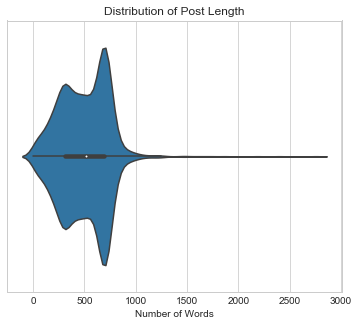

In [53]:
post_lengths = [len(body) for body in tokenized_bodies]
sns.violinplot(post_lengths)
plt.title('Distribution of Post Length')
plt.xlabel('Number of Words')

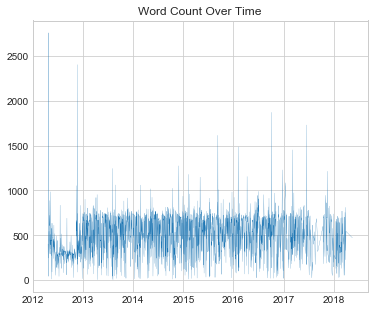

In [54]:
plt.plot(dates, post_lengths, lw=.2)
plt.title('Word Count Over Time')

**Common and unique topics**

In [55]:
# Most common ngrams 
from collections import Counter

fivegrams = [item for item in [item for sublist in 
                               [list(ngrams(tokens, 5)) 
                                for tokens in tokenized_bodies] for item in sublist]
             if '' not in item] 
fivegrams = Counter(fivegrams) 
fivegrams.most_common(20)

[(('love', 'to', 'hear', 'from', 'you'), 71),
 (('i', 'would', 'love', 'to', 'hear'), 64),
 (('i', 'd', 'love', 'to', 'hear'), 62),
 (('would', 'love', 'to', 'hear', 'from'), 44),
 (('feel', 'free', 'to', 'email', 'me'), 36),
 (('the', 'rest', 'of', 'my', 'life'), 32),
 (('d', 'love', 'to', 'hear', 'from'), 32),
 (('for', 'introducing', 'me', 'to', 'the'), 27),
 (('if', 'you', 'd', 'like', 'to'), 26),
 (('the', 'world', 'a', 'better', 'place'), 25),
 (('at', 'the', 'end', 'of', 'the'), 24),
 (('introducing', 'me', 'to', 'the', 'listserve'), 24),
 (('in', 'the', 'middle', 'of', 'the'), 22),
 (('i', 'don', 't', 'want', 'to'), 21),
 (('for', 'the', 'first', 'time', 'in'), 21),
 (('feel', 'free', 'to', 'reach', 'out'), 19),
 (('if', 'you', 'would', 'like', 'to'), 18),
 (('if', 'you', 'want', 'to', 'talk'), 18),
 (('i’d', 'love', 'to', 'hear', 'from'), 18),
 (('make', 'the', 'world', 'a', 'better'), 17)]

In [9]:
trigrams = [item for item in [item for sublist in 
                              [list(ngrams(tokens, 3)) 
                               for tokens in tokenized_bodies] for item in sublist]
            if '' not in item]
trigrams = Counter(trigrams) 
trigrams.most_common(20)

[(('i', 'want', 'to'), 379),
 (('i', 'don', 't'), 363),
 (('a', 'lot', 'of'), 336),
 (('one', 'of', 'the'), 266),
 (('you', 'want', 'to'), 239),
 (('when', 'i', 'was'), 207),
 (('love', 'to', 'hear'), 205),
 (('of', 'my', 'life'), 197),
 (('if', 'you', 're'), 189),
 (('i', 'have', 'a'), 188),
 (('if', 'you', 'have'), 186),
 (('if', 'you', 'want'), 186),
 (('in', 'my', 'life'), 183),
 (('to', 'be', 'a'), 175),
 (('in', 'the', 'world'), 174),
 (('feel', 'free', 'to'), 173),
 (('i', 'm', 'a'), 172),
 (('i', 'm', 'not'), 168),
 (('i', 'wanted', 'to'), 162),
 (('i', 'am', 'a'), 158)]

In [56]:
tokens = [token for body in tokenized_bodies for token in body if token != '' and token not in stop_words]
unigrams = Counter(tokens) 
unigrams.most_common(10)

[('people', 2690),
 ('life', 2654),
 ('like', 2601),
 ('one', 2584),
 ('time', 2256),
 ('love', 2105),
 ('know', 1995),
 ('would', 1962),
 ('get', 1665),
 ('things', 1544)]

In [60]:
unigrams = dict(unigrams)

# Normalize by word count 
unigram_vals = np.array([sum([unigrams[token] for token in body if token != '' and token not in stop_words])
                for body in tokenized_bodies])
most_generic = np.argmax(unigram_vals)
most_unique = np.argmin(unigram_vals)

In [61]:
# Most generic 
bodies[most_generic]

'When I turned twenty I had reached a point where my earthly possessions could be summarized as the clothes I was wearing, an old bag containing some more clothes, a few science-fiction books, and my guitar. No money, no place to live, just a bunch of friends who helped me out of the streets and put me back on my feet. Ending up in such a pit you first feel anger, then sorrow, then you make fun of it because that is the only way to make it bearable, and then you can go forward. It took me three more years to be able to shop for food without having to count change in my pockets. Twenty years later I gave the books away but I still keep the old bag as a memory and my guitar is now standing in the living-room where I occasionally use it to sing for my kids. Life has been a tough ride so far, but at least I know how to live without being bothered by simple objects. I know the only things you can count on are:- What is inside you: your skills, your knowledge- Good friends, and other people 

In [63]:
bodies[most_unique]

'Blake, Even with this weird opportunity to send a message to 21,422 people, I’d rather just send you a birthday note. So, listen up: You are f$%&ing awesome. I know it’s been a pretty weird (weird = kind of crappy and also legitimately weird) year for you, but you’re less than a week away from a fresh start. Last year you: Took a paid sabbatical.Tried stand up comedy.Realized stand up comedy was not your jam and tried writing funny stuff instead.Wrote funny stuff.Helped a lot of vets.Stopped being a vegan.Became one of my best friends. This year you will: Realize that you are f$%&ing awesome.Try improv comedy.Tell someone exactly why he or she should hire you and believe it.Tell your dumb boss exactly what you think (at least once).Teach someone else how to be a great friend who does things like sending text messages at 8:25 AM on Monday mornings that say “Here’s to a good week!” even though you know it won’t be.Re-read Fierce Invalids and learn something new about Switters. I know yo

In [83]:
# Topic Exploration
import gensim
import gensim.corpora as corpora 

import pyLDAvis
import pyLDAvis.gensim  

wordnet = WordNetLemmatizer()
def stem(word_list): 
    return [wordnet.lemmatize(word) for word in word_list if word != '' and word not in stop_words]

stemmed_tokens = [stem(tokens) for tokens in tokenized_bodies]

id2word = corpora.Dictionary(stemmed_tokens)

In [84]:
corpus = [id2word.doc2bow(text) for text in stemmed_tokens]

In [100]:
model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=10, 
                                        random_state=0,
                                        update_every=1,
                                        chunksize=100,
                                        passes=10,
                                        alpha='auto',
                                        per_word_topics=True)

In [96]:
model.print_topics()

[(0,
  '0.012*"cup" + 0.012*"de" + 0.010*"1" + 0.009*"oven" + 0.009*"recipe" + 0.007*"que" + 0.007*"e" + 0.007*"mix" + 0.006*"bowl" + 0.006*"ingredient"'),
 (1,
  '0.010*"day" + 0.010*"year" + 0.009*"back" + 0.008*"one" + 0.008*"first" + 0.007*"friend" + 0.007*"home" + 0.006*"away" + 0.005*"could" + 0.005*"night"'),
 (2,
  '0.012*"gaius" + 0.010*"code" + 0.010*"\u3000" + 0.009*"marcus" + 0.006*"draw" + 0.005*"usual" + 0.005*"approach" + 0.005*"bagel" + 0.004*"cost" + 0.004*"crime"'),
 (3,
  '0.012*"2" + 0.012*"1" + 0.010*"3" + 0.009*"work" + 0.008*"4" + 0.007*"project" + 0.007*"5" + 0.006*"use" + 0.006*"game" + 0.006*"company"'),
 (4,
  '0.018*"life" + 0.015*"thing" + 0.014*"like" + 0.013*"time" + 0.013*"people" + 0.012*"one" + 0.012*"know" + 0.011*"love" + 0.010*"make" + 0.009*"get"'),
 (5,
  '0.013*"world" + 0.011*"u" + 0.010*"people" + 0.009*"many" + 0.007*"human" + 0.006*"problem" + 0.006*"change" + 0.006*"number" + 0.006*"others" + 0.005*"may"'),
 (6,
  '0.017*"water" + 0.016*"foo

In [101]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      50.473339        1       1 -0.331489  0.065714
4      22.058573        1       2 -0.324945 -0.055592
9       6.791382        1       3 -0.160326 -0.014852
7       4.044267        1       4  0.098257  0.281166
8       3.757324        1       5  0.074957 -0.148070
2       3.310316        1       6  0.095816 -0.144717
3       2.607815        1       7  0.112813  0.088386
6       2.560613        1       8  0.132923  0.040231
5       2.508508        1       9  0.142908 -0.075273
0       1.887868        1      10  0.159086 -0.036993, topic_info=      Category         Freq        Term        Total  loglift  logprob
term                                                                  
3390   Default   983.000000               983.000000  30.0000  30.0000
96     Default  2691.000000      people  2691.000000  29.0000  29.0000
1777   Default   571.000000           2   571.000000  28.0000  28.0000
1918   Default   582.000000           1   582.000000  27.0000  27.0000
138    Default  2635.000000       thing  2635.000000  26.0000  26.0000
545    Default   479.000000           3   479.000000  25.0000  25.0000
1540   Default   384.000000           4   384.000000  24.0000  24.0000
462    Default   925.000000         i’m   925.000000  23.0000  23.0000
157    Default  2126.000000        year  2126.000000  22.0000  22.0000
289    Default  1265.000000       world  1265.000000  21.0000  21.0000
286    Default  1224.000000        work  1224.000000  20.0000  20.0000
26     Default  1919.000000         day  1919.000000  19.0000  19.0000
79     Default  1908.000000        make  1908.000000  18.0000  18.0000
105    Default   575.000000         put   575.000000  17.0000  17.0000
285    Default   594.000000        word   594.000000  16.0000  16.0000
1822   Default   351.000000      minute   351.000000  15.0000  15.0000
1246   Default   345.000000           5   345.000000  14.0000  14.0000
69     Default  2099.000000        know  2099.000000  13.0000  13.0000
72     Default  2483.000000        like  2483.000000  12.0000  12.0000
356    Default  1498.000000       think  1498.000000  11.0000  11.0000
281    Default  1538.000000        want  1538.000000  10.0000  10.0000
960    Default   463.000000        hour   463.000000   9.0000   9.0000
233    Default   877.000000        need   877.000000   8.0000   8.0000
71     Default  3117.000000        life  3117.000000   7.0000   7.0000
311    Default   585.000000       don’t   585.000000   6.0000   6.0000
326    Default   723.000000        it’s   723.000000   5.0000   5.0000
205    Default  1680.000000         get  1680.000000   4.0000   4.0000
225    Default  2026.000000        love  2026.000000   3.0000   3.0000
3612   Default   232.000000           e   232.000000   2.0000   2.0000
186    Default   308.000000     country   308.000000   1.0000   1.0000
...        ...          ...         ...          ...      ...      ...
6217   Topic10    18.519697    terribly    19.312773   3.9278  -6.0428
7267   Topic10    18.299421        bell    19.092249   3.9273  -6.0548
3379   Topic10    18.035789       snake    18.829792   3.9266  -6.0693
11358  Topic10    17.717262     pressed    18.511261   3.9259  -6.0871
31549  Topic10    17.515064          　　    18.307720   3.9255  -6.0986
7347   Topic10    17.499372   nostalgia    18.293535   3.9253  -6.0995
3276   Topic10    17.496319    notebook    18.290590   3.9253  -6.0997
5844   Topic10    17.400997    bothered    18.199503   3.9249  -6.1051
2451   Topic10    17.067352      outfit    17.862623   3.9242  -6.1245
11863  Topic10    16.556805    attacked    17.351826   3.9228  -6.1549
6195   Topic10    16.389013   remainder    17.185148   3.9223  -6.1651
5884   Topic10    16.065002      pissed    16.858557   3.9215  -6.1850
3773   Topic10    15.879600    educated    16.672684   3.9210  -6.1966
16349  Topic10    15.724541           o    